# Case 2: Siemens AI-Driven Sales Forecasting

## Overview
This case study involves building a monthly sales forecasting model using real sales data from Siemens’ Smart Infrastructure Division in Germany. The objective is to apply machine learning techniques to predict future sales based on historical data and macro-economic indicators.

## Business Problem
- Manual sales forecasting is time-consuming and relies on human judgment.
- Data is scattered across multiple sources, making it difficult to derive insights.
- Inaccurate forecasts lead to financial losses, such as inefficient inventory management and unsatisfied customers.

## Objective
- Develop an AI-driven predictive model to automate the forecasting process.
- Evaluate the model using Root Mean Squared Error (RMSE).
- Submit predictions for May 2022 - February 2023 in a structured CSV format. 

## This notebook was developed by:

- João Venichand - 20211644
- Gonçalo Custódio - 20211643
- Diogo Correia - 20211586
- Duarte Emanuel - 20240564


# 1. Importing Libraries

In [1675]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# 2. Load Datasets

In [1676]:
sales_data = pd.read_csv("sales_data.csv")
market_data = pd.read_excel("market_data.xlsx", skiprows=2)
test_set = pd.read_csv("test_set_template.csv")

In [1677]:
print(sales_data.head())
print(sales_data.info())
print(sales_data.describe())

         DATE Mapped_GCK  Sales_EUR
0  01.10.2018         #1          0
1  02.10.2018         #1          0
2  03.10.2018         #1          0
3  04.10.2018         #1          0
4  05.10.2018         #1          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 229.9+ KB
None
          Sales_EUR
count  9.802000e+03
mean   2.727856e+05
std    2.230789e+06
min   -5.063810e+05
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    4.112799e+07


In [1678]:
print(market_data.head())
print(market_data.info())
print(market_data.describe())

      date  MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  \
0   2004m2       16.940704       16.940704      112.091273       83.458866   
1   2004m3       23.711852       23.711852      136.327976      106.168192   
2   2004m4       24.435235       24.435235      117.791806       92.007646   
3   2004m5       23.708115       23.708115      109.002541       85.696486   
4   2004m6       27.009138       27.009138      133.785737      106.641482   

   MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  \
0       82.623037       79.452532      124.289603       86.560493   
1      100.556582       97.012918      143.411662      106.344544   
2       89.653203       84.932358      129.083828       95.579673   
3       86.880571       82.372794      135.590391      100.087039   
4       99.010814       95.108740      136.424935      110.889719   

   MAB_ELE_PRO392  ...  PRO28250_org  PRO28276_org  PRO27840_org  \
0      109.334010  ...    118.274109     80.8290

In [1679]:
print(test_set.head())
print(test_set.info())
print(test_set.describe())

  Month Year Mapped_GCK  Sales_EUR
0     Mai 22         #3        NaN
1     22-Jun         #3        NaN
2     22-Jul         #3        NaN
3     22-Aug         #3        NaN
4     22-Sep         #3        NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month Year  140 non-null    object 
 1   Mapped_GCK  140 non-null    object 
 2   Sales_EUR   0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 3.4+ KB
None
       Sales_EUR
count        0.0
mean         NaN
std          NaN
min          NaN
25%          NaN
50%          NaN
75%          NaN
max          NaN


# 3. Data Exploration & Quality Check

Data Types

In [1680]:
print(sales_data.dtypes)

DATE          object
Mapped_GCK    object
Sales_EUR      int64
dtype: object


Check Missing Values

In [1681]:
print(sales_data.isnull().sum())

DATE          0
Mapped_GCK    0
Sales_EUR     0
dtype: int64


In [1682]:
print(market_data.isnull().sum())

date                       0
MAB_ELE_PRO156             0
MAB_ELE_SHP156             0
MAB_ELE_PRO250             0
MAB_ELE_SHP250             0
MAB_ELE_PRO276             0
MAB_ELE_SHP276             0
MAB_ELE_PRO380             0
MAB_ELE_SHP380             0
MAB_ELE_PRO392             0
MAB_ELE_SHP392             0
MAB_ELE_PRO756             1
MAB_ELE_SHP756             1
MAB_ELE_PRO826             0
MAB_ELE_SHP826            18
MAB_ELE_PRO840             0
MAB_ELE_SHP840             1
MAB_ELE_PRO1100            0
MAB_ELE_SHP1100            0
RohiBASEMET1000_org        0
RohiENERGY1000_org         0
RohiMETMIN1000_org         0
RohiNATGAS1000_org         0
RohCRUDE_PETRO1000_org     0
RohCOPPER1000_org          0
WKLWEUR840_org             0
PRI27840_org               0
PRI27826_org              18
PRI27380_org               0
PRI27250_org              35
PRI27276_org               0
PRI27156_org              23
PRO28840_org               0
PRO281000_org              0
PRO28756_org  

In [1683]:
print(test_set.isnull().sum())

Month Year      0
Mapped_GCK      0
Sales_EUR     140
dtype: int64


Duplicated Values Check

In [1684]:
print("Duplicate Rows in Sales Data:", sales_data.duplicated().sum())
print("Duplicate Rows in Market Data:", market_data.duplicated().sum())
print("Duplicate Rows in Test Set:", test_set.duplicated().sum())

Duplicate Rows in Sales Data: 0
Duplicate Rows in Market Data: 0
Duplicate Rows in Test Set: 0


Outliers Check

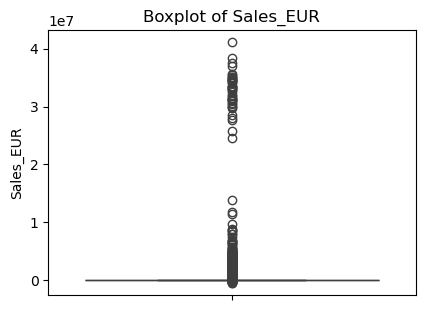

In [1685]:
num_cols = sales_data.select_dtypes(include=['number']).columns

plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=sales_data[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
plt.show()

In [1686]:
z_scores = np.abs(zscore(sales_data.select_dtypes(include=['number'])))
threshold = 3
outliers = (z_scores > threshold).sum()

print("Number of Outliers per Column:")
print(outliers)

Number of Outliers per Column:
Sales_EUR    53
dtype: int64


# 4. Data Cleaning and Preprocessing

Fill missing values in test_set

In [1687]:
test_set['Sales_EUR'].fillna(0, inplace=True)

C:\Users\gonca\AppData\Local\Temp\ipykernel_21972\239829453.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_set['Sales_EUR'].fillna(0, inplace=True)


Forward-fill missing values in market_data

In [1688]:
market_data.fillna(method='ffill', inplace=True)

C:\Users\gonca\AppData\Local\Temp\ipykernel_21972\368739243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_data.fillna(method='ffill', inplace=True)


Apply Log Transformation to the Outliers

In [1689]:
sales_data['Sales_EUR'] = np.where(sales_data['Sales_EUR'] < 0, 0, sales_data['Sales_EUR'])
sales_data['Sales_EUR'] = np.log1p(sales_data['Sales_EUR'])

Convert DATE column to datetime format

In [1690]:
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], format="%d.%m.%Y", errors='coerce')

Extract year and month

In [1691]:
sales_data['YearMonth'] = sales_data['DATE'].dt.to_period('M').astype(str)

Aggregate sales to monthly level

In [1692]:
monthly_sales = sales_data.groupby(['YearMonth', 'Mapped_GCK'], as_index=False).agg({'Sales_EUR': 'sum'})

Convert YearMonth back to datetime for merging

In [1693]:
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['YearMonth']) + pd.offsets.MonthBegin(0)

Sales Over Time

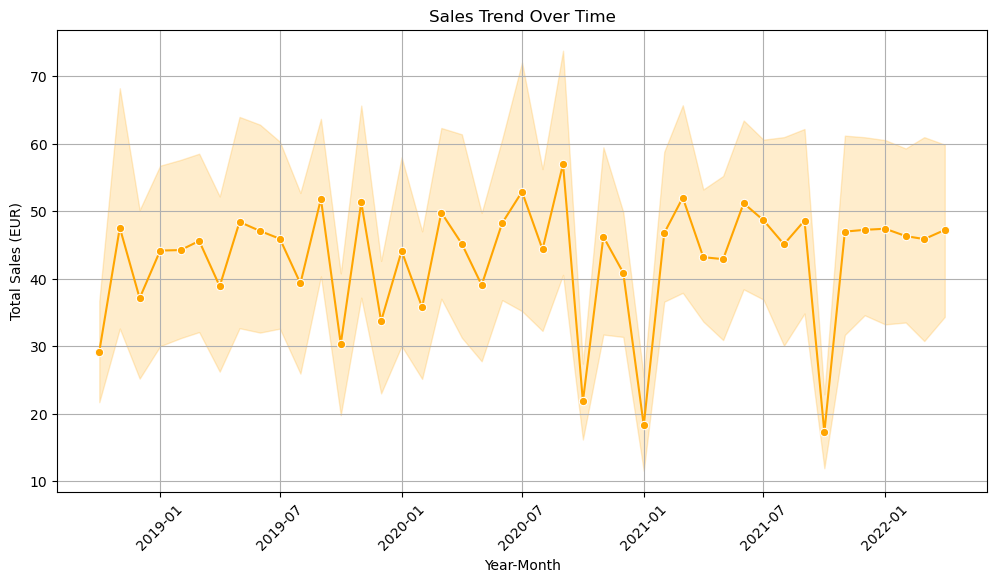

In [1694]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="YearMonth", y="Sales_EUR", marker="o", linestyle="-", color="orange")
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Total Sales (EUR)")
plt.title("Sales Trend Over Time")
plt.grid(True)
plt.show()

Sales Distribution Histogram

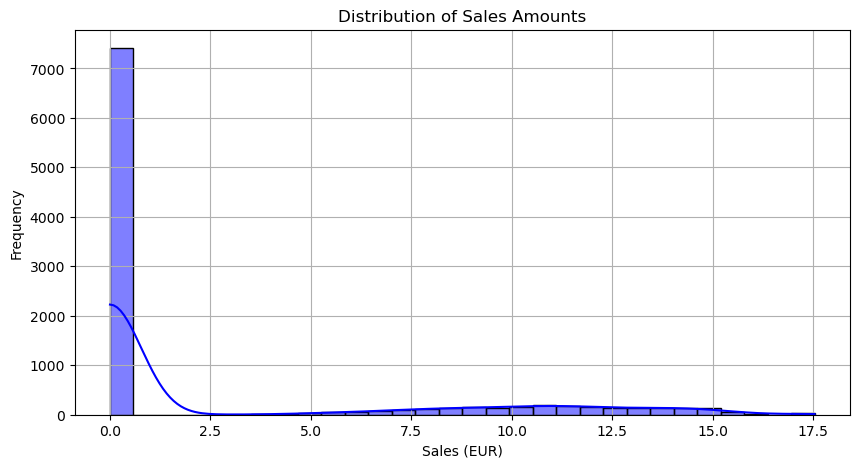

In [1695]:
plt.figure(figsize=(10, 5))
sns.histplot(sales_data["Sales_EUR"], bins=30, kde=True, color="blue", edgecolor="black")
plt.xlabel("Sales (EUR)")
plt.ylabel("Frequency")
plt.title("Distribution of Sales Amounts")
plt.grid(True)
plt.show()

Sales per Product Group (Mapped_GCK)

C:\Users\gonca\AppData\Local\Temp\ipykernel_21972\3839060230.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_sales, x="Mapped_GCK", y="Sales_EUR", palette="viridis")


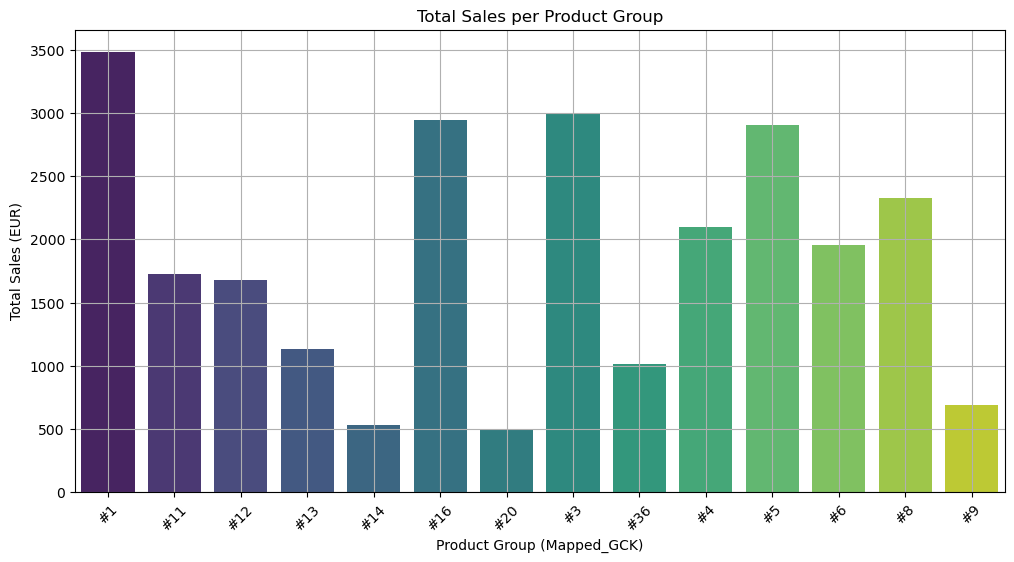

In [1696]:
plt.figure(figsize=(12, 6))
grouped_sales = sales_data.groupby("Mapped_GCK")["Sales_EUR"].sum().reset_index()
sns.barplot(data=grouped_sales, x="Mapped_GCK", y="Sales_EUR", palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Product Group (Mapped_GCK)")
plt.ylabel("Total Sales (EUR)")
plt.title("Total Sales per Product Group")
plt.grid(True)
plt.show()

### 4.1 Extract Relevant Macroeconomic Indicators

Select relevant macroeconomic indicators for USA, China, and Germany

In [1697]:
market_data.rename(columns={"date": "YearMonth"}, inplace=True)
print(market_data[['YearMonth']].head(15))

   YearMonth
0     2004m2
1     2004m3
2     2004m4
3     2004m5
4     2004m6
5     2004m7
6     2004m8
7     2004m9
8    2004m10
9    2004m11
10   2004m12
11    2005m1
12    2005m2
13    2005m3
14    2005m4


In [1698]:
market_data['YearMonth'] = market_data['YearMonth'].astype(str)
market_data['Year'] = market_data['YearMonth'].str[:4]
market_data['Month'] = market_data['YearMonth'].str[5:].str.zfill(2)

In [1699]:
market_data['YearMonth'] = pd.to_datetime(market_data['Year'] + "-" + market_data['Month'] + "-01", errors='coerce')
market_data.drop(columns=["Year", "Month"], inplace=True)
print(market_data[['YearMonth']].head(10))

   YearMonth
0        NaT
1        NaT
2        NaT
3        NaT
4        NaT
5        NaT
6        NaT
7        NaT
8 2004-10-01
9 2004-11-01


C:\Users\gonca\AppData\Local\Temp\ipykernel_21972\2980751671.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  market_data['YearMonth'] = pd.to_datetime(market_data['Year'] + "-" + market_data['Month'] + "-01", errors='coerce')


In [1700]:
market_data = market_data.dropna(subset=['YearMonth'])
market_data.reset_index(drop=True, inplace=True)
print(market_data[['YearMonth']].head(10))

   YearMonth
0 2004-10-01
1 2004-11-01
2 2004-12-01
3 2005-10-01
4 2005-11-01
5 2005-12-01
6 2006-10-01
7 2006-11-01
8 2006-12-01
9 2007-10-01


In [1701]:
selected_columns = [
    "YearMonth",  
    "MAB_ELE_PRO156", "MAB_ELE_SHP156",  # China
    "MAB_ELE_PRO276", "MAB_ELE_SHP276",  # Germany
    "MAB_ELE_PRO840", "MAB_ELE_SHP840"   # USA
]

market_data_filtered = market_data[selected_columns].copy()
print(market_data_filtered.head())

   YearMonth  MAB_ELE_PRO156  MAB_ELE_SHP156  MAB_ELE_PRO276  MAB_ELE_SHP276  \
0 2004-10-01       24.895962       24.895962       93.519358       89.045549   
1 2004-11-01       26.774785       26.774785       97.130763       93.852657   
2 2004-12-01       32.733756       32.733756      102.344549      105.033970   
3 2005-10-01       33.799609       33.799609       94.614611       89.800315   
4 2005-11-01       37.686119       37.686119      105.154061      101.688290   

   MAB_ELE_PRO840  MAB_ELE_SHP840  
0      110.445124       91.011662  
1      109.607827       86.753335  
2      105.616716       96.128888  
3      115.583350      100.255966  
4      114.283339       96.317366  


Merge datasets on YearMonth

In [1702]:
sales_data['YearMonth'] = pd.to_datetime(sales_data['YearMonth'])
market_data_filtered['YearMonth'] = pd.to_datetime(market_data_filtered['YearMonth'])
data = sales_data.merge(market_data_filtered, on="YearMonth", how="left")

print(data.head())

        DATE Mapped_GCK  Sales_EUR  YearMonth  MAB_ELE_PRO156  MAB_ELE_SHP156  \
0 2018-10-01         #1        0.0 2018-10-01      211.955755      211.955755   
1 2018-10-02         #1        0.0 2018-10-01      211.955755      211.955755   
2 2018-10-03         #1        0.0 2018-10-01      211.955755      211.955755   
3 2018-10-04         #1        0.0 2018-10-01      211.955755      211.955755   
4 2018-10-05         #1        0.0 2018-10-01      211.955755      211.955755   

   MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO840  MAB_ELE_SHP840  
0      124.227879      137.741953       111.90254      127.808839  
1      124.227879      137.741953       111.90254      127.808839  
2      124.227879      137.741953       111.90254      127.808839  
3      124.227879      137.741953       111.90254      127.808839  
4      124.227879      137.741953       111.90254      127.808839  


# 5. Correlation Matrix

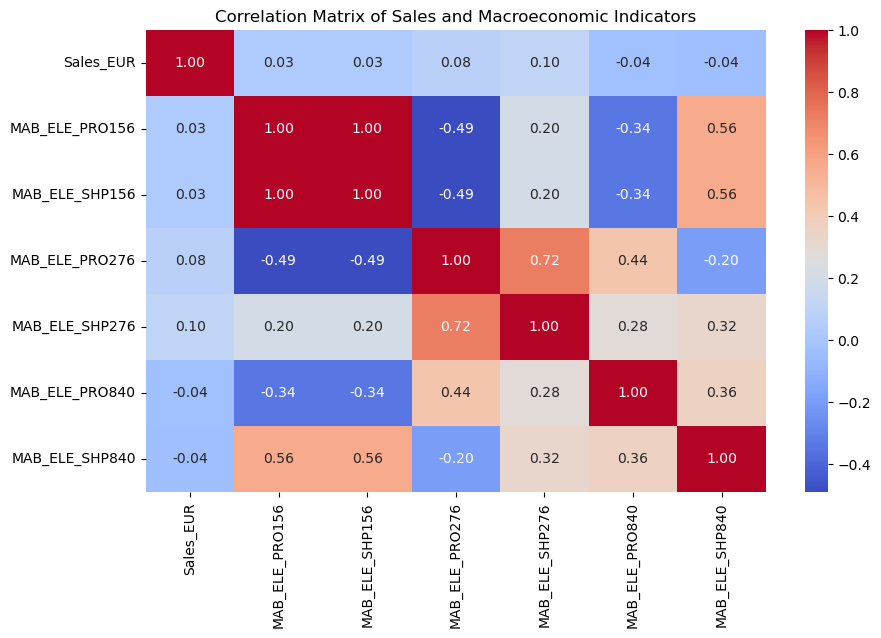

In [1703]:
numeric_data = data.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Sales and Macroeconomic Indicators")
plt.show()

In [1704]:
lags = [1, 2]
data.sort_values(by="YearMonth", inplace=True)

for col in data.columns:
    if col not in ["Sales_EUR", "YearMonth"]:
        for lag in lags:
            data[f"{col}_lag{lag}"] = data[col].shift(lag)

data.dropna(inplace=True)
print(data.head())

           DATE Mapped_GCK  Sales_EUR  YearMonth  MAB_ELE_PRO156  \
4193 2018-10-31         #3  13.702052 2018-10-01      211.955755   
4194 2018-10-29        #20   8.346642 2018-10-01      211.955755   
8375 2018-10-16         #3   0.000000 2018-10-01      211.955755   
8376 2018-10-09         #5   0.000000 2018-10-01      211.955755   
8377 2018-10-23         #5   0.000000 2018-10-01      211.955755   

      MAB_ELE_SHP156  MAB_ELE_PRO276  MAB_ELE_SHP276  MAB_ELE_PRO840  \
4193      211.955755      124.227879      137.741953       111.90254   
4194      211.955755      124.227879      137.741953       111.90254   
8375      211.955755      124.227879      137.741953       111.90254   
8376      211.955755      124.227879      137.741953       111.90254   
8377      211.955755      124.227879      137.741953       111.90254   

      MAB_ELE_SHP840  ... MAB_ELE_SHP156_lag1 MAB_ELE_SHP156_lag2  \
4193      127.808839  ...          211.955755          211.955755   
4194      127.808839

# 6. Feature Selection

In [1705]:
corr_matrix = numeric_data.corr()
sales_corr = corr_matrix["Sales_EUR"].abs()
corr_threshold = 0.05
selected_features = list(set(sales_corr.nlargest(10).index.tolist() + ["Sales_EUR"]))
data = data[selected_features]

print(sales_corr.sort_values(ascending=False))
print("Selected features:", selected_features)

Sales_EUR         1.000000
MAB_ELE_SHP276    0.103698
MAB_ELE_PRO276    0.076674
MAB_ELE_SHP840    0.038144
MAB_ELE_PRO840    0.036201
MAB_ELE_PRO156    0.030570
MAB_ELE_SHP156    0.030570
Name: Sales_EUR, dtype: float64
Selected features: ['MAB_ELE_SHP156', 'MAB_ELE_SHP840', 'MAB_ELE_PRO840', 'Sales_EUR', 'MAB_ELE_SHP276', 'MAB_ELE_PRO156', 'MAB_ELE_PRO276']


# 7. Split

In [1706]:
target = "Sales_EUR"
X_train, X_test, y_train, y_test = train_test_split(data, data[target], test_size=0.2, random_state=42, shuffle=False)

# 8. Scaling

In [1707]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 9. XGB

In [1708]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)
rmse_xgb

c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0926639717992135

# 10. SARIMAX

In [1709]:
sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit()
y_pred_sarima = sarima_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
rmse_sarima = mean_squared_error(y_test, y_pred_sarima, squared=False)
rmse_sarima

c:\Users\gonca\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gonca\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gonca\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gonca\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: Future

5.189678336688647

# 11. RF

In [1710]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
rmse_rf

c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.026689840177708875

In [1711]:
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"SARIMA RMSE: {rmse_sarima}")
print(f"Random Forest RMSE: {rmse_rf}")

best_model = min([(rmse_xgb, "XGBoost"), (rmse_sarima, "SARIMA"), (rmse_rf, "Random Forest")])
print("Best Model:", best_model[1])

XGBoost RMSE: 0.0926639717992135
SARIMA RMSE: 5.189678336688647
Random Forest RMSE: 0.026689840177708875
Best Model: Random Forest


Sales Trend Over Time with RF Prediction

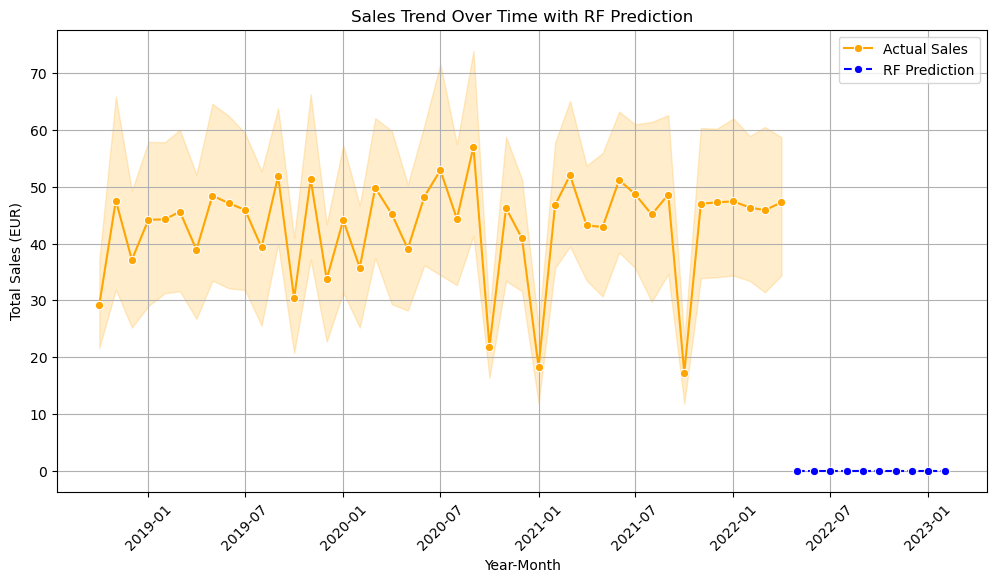

In [1712]:
future_dates = pd.date_range(start=monthly_sales["YearMonth"].max(), periods=11, freq="MS")[1:]
rf_predictions_df = pd.DataFrame({
    "YearMonth": future_dates,
    "RF_Prediction": y_pred_rf[:10]
})

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="YearMonth", y="Sales_EUR", marker="o", linestyle="-", color="orange", label="Actual Sales")
sns.lineplot(data=rf_predictions_df, x="YearMonth", y="RF_Prediction", marker="o", linestyle="--", color="blue", label="RF Prediction")
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Total Sales (EUR)")
plt.title("Sales Trend Over Time with RF Prediction")
plt.grid(True)
plt.legend()
plt.show()

Plot actual vs predicted sales - RF

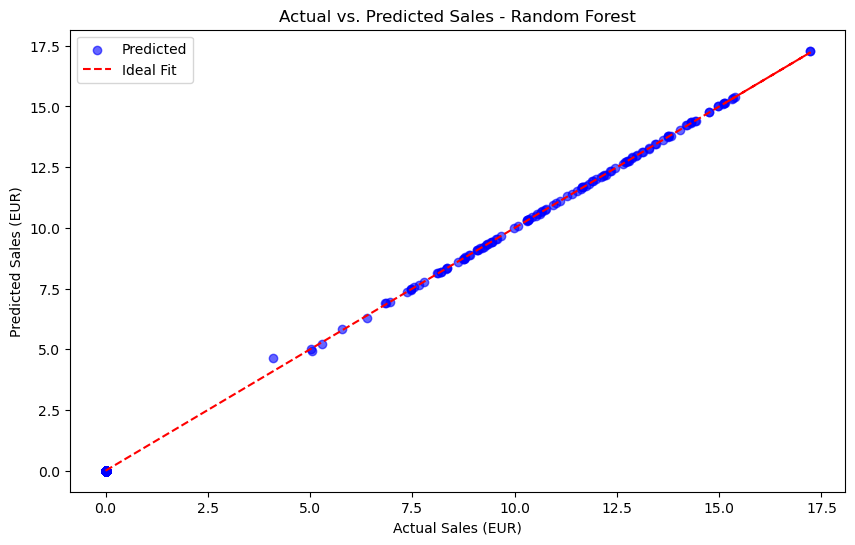

In [1713]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="Predicted", color="blue")
plt.plot(y_test, y_test, linestyle="dashed", color="red", label="Ideal Fit")
plt.xlabel("Actual Sales (EUR)")
plt.ylabel("Predicted Sales (EUR)")
plt.title("Actual vs. Predicted Sales - Random Forest")
plt.legend()
plt.show()

Compute residuals (errors) - RF

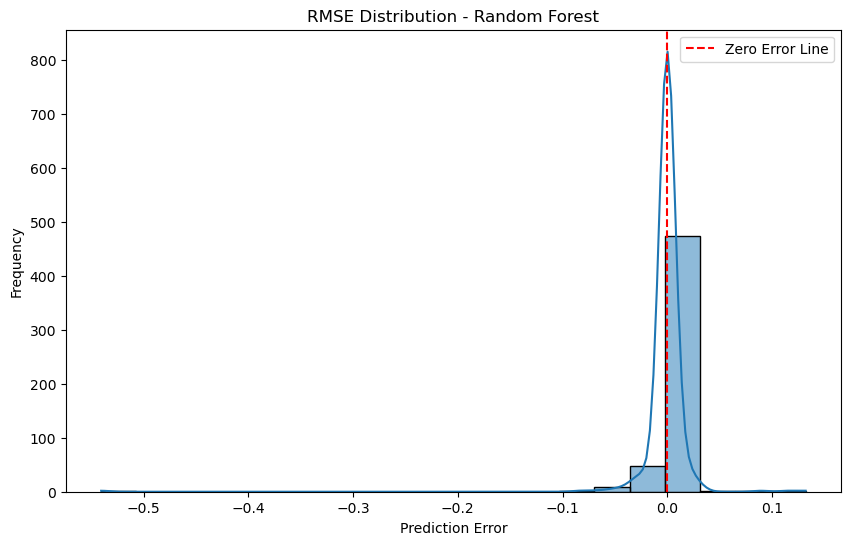

In [1714]:
errors = y_test - y_pred_rf

plt.figure(figsize=(10,6))
sns.histplot(errors, bins=20, kde=True)
plt.axvline(x=0, color='red', linestyle='dashed', label="Zero Error Line")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("RMSE Distribution - Random Forest")
plt.legend()
plt.show()